In this assignment you will continue working with the housing price per district from the previous module assignment, this time training SVM models, both for regression and classification.

#### Getting the data for the assignment

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [7]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [8]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [9]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [10]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [11]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


### Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [12]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.3, random_state=42)

### Features

In [13]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [14]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

### Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

#### Comparing models

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### Linear regression on original features (no transformations) --- benchmark

In [17]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [70142.55721218 67456.39127204 67318.3258893  70866.26065275]
Mean: 68945.88375656874


### 1. Support Vector Machines for Regression

#### (a) In this exercise your goal is to tune SVR with FBR kernel, and make the average score mean_squared_error over 3-folds (cv=3) below 58000. 

You are encouraged to try optimizing any of the hyper-parameters of SVR

See http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html for more details

However, as a hint, you can focus on C and gamma. 

Hint 2: if when you try different values for a hyper-parameter, the optimal models corresponds to one of the extreme values in your range, that probably means you can keep improving your solution by considering values beyond the current range.



In [17]:
from sklearn.svm import SVR

C_vals = [1, 10, 100, 1000, 100000] 
gamma_vals = [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9]

param_grid = [{'C':C_vals, 'gamma':gamma_vals}]
grid_search_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3,scoring='neg_mean_squared_error')
grid_search_rbf.fit(X_tr, np.ravel(y_tr))

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [1, 10, 100, 1000, 100000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [18]:
print(grid_search_rbf.best_params_)
print(np.sqrt(-grid_search_rbf.best_score_))

{'C': 100000, 'gamma': 0.2}
56411.595579469365


### Performance on Test Set

In [19]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_rbf.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

55227.58787208683


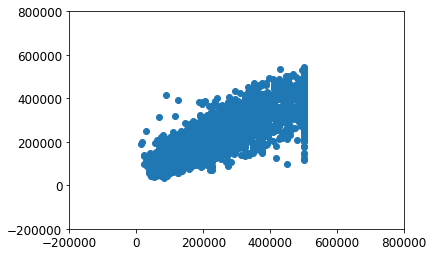

In [20]:
import matplotlib.pyplot as plt

plt.scatter(x=y_te, y=y_te_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

### 2. SVM for Classification

Now we transform the continuous target into a binary variable, indicating whether or not the price is above the average $179700


In [21]:
from sklearn.metrics import accuracy_score

In [22]:
np.median(housing[['median_house_value']])

179700.0

#### Binary target variable

In [23]:
y_tr_b = 1*np.ravel(y_tr>=179700.0)
y_te_b = 1*np.ravel(y_te>=179700.0)

#### Linear SVM for classification

In [24]:
from sklearn.svm import LinearSVC

In [25]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_tr, y_tr_b)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [26]:
y_pred = lin_clf.predict(X_tr)
accuracy_score(y_tr_b, y_pred)

0.8385935769656699

### (a) Does SVC (with default hyper-parameters) improve the performance of the linear SVM?

In [27]:
from sklearn.svm import SVC

In [28]:
from sklearn import svm
from sklearn.svm import LinearSVR

C = 0.001
clf = svm.SVC(kernel='linear', C=C)
svm_lin_svc = svm.LinearSVC(C=C, loss='hinge')

clf.fit(X_tr, y_tr_b)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [29]:
y_pred_svm_svc = clf.predict(X_tr)
accuracy_score(y_tr_b, y_pred_svm_svc)

0.8211517165005537

In [30]:
svm_lin_svc.fit(X_tr, y_tr_b)

LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [31]:
y_pred_svm_lin_svc = svm_lin_svc.predict(X_tr)
accuracy_score(y_tr_b, y_pred_svm_lin_svc)

0.8207364341085271

In [32]:
from sklearn.svm import LinearSVC
lin_svc = LinearSVC(random_state=42)

lin_svc.fit(X_tr, y_tr_b)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [33]:
y_pred_lin_svc = lin_svc.predict(X_tr)
accuracy_score(y_tr_b, y_pred_lin_svc)

0.8385935769656699

### (b) Use randomized search to tune hyper-parameters of SVC and improve its performance

In [34]:
svc = SVC(decision_function_shape="ovr", gamma="auto")
svc.fit(X_tr[:10000], y_tr[:10000])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [47]:
y_pred_svc = svc.predict(X_tr)

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svc, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_tr[:1000], y_tr[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=5.284709261868257, gamma=0.024086278856848574 .................
[CV] .. C=5.284709261868257, gamma=0.024086278856848574, total=   0.1s
[CV] C=5.284709261868257, gamma=0.024086278856848574 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .. C=5.284709261868257, gamma=0.024086278856848574, total=   1.5s
[CV] C=5.284709261868257, gamma=0.024086278856848574 .................
[CV] .. C=5.284709261868257, gamma=0.024086278856848574, total=   1.4s
[CV] C=8.191503101547731, gamma=0.009599262475156864 .................
[CV] .. C=8.191503101547731, gamma=0.009599262475156864, total=   0.1s
[CV] C=8.191503101547731, gamma=0.009599262475156864 .................
[CV] .. C=8.191503101547731, gamma=0.009599262475156864, total=   1.5s
[CV] C=8.191503101547731, gamma=0.009599262475156864 .................
[CV] .. C=8.191503101547731, gamma=0.009599262475156864, total=   1.4s
[CV] C=8.800277619120791, gamma=0.0066351194450833505 ................
[CV] . C=8.800277619120791, gamma=0.0066351194450833505, total=   0.1s
[CV] C=8.800277619120791, gamma=0.0066351194450833505 ................
[CV] . C=8.800277619120791, gamma=0.0066351194450833505, total=   1.5s
[CV] C=8.800277619120791, gamma=0.0066351194450833505 ................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.1min finished
/Users/hariprani/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a196172e8>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a196177b8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [39]:
rnd_search_cv.best_estimator_

SVC(C=5.284709261868257, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.024086278856848574,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [40]:
rnd_search_cv.best_score_

0.066

In [41]:
rnd_search_cv.best_estimator_.fit(X_tr, y_tr_b)

SVC(C=5.284709261868257, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.024086278856848574,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [42]:
y_pred = rnd_search_cv.best_estimator_.predict(X_tr)
accuracy_score(y_tr_b, y_pred)

0.8655869324473976

In [44]:
y_pred_rnd = rnd_search_cv.best_estimator_.predict(X_te)
accuracy_score(y_te_b, y_pred_rnd)

0.8622416020671835

### Submit your notebook

Submit your solution on Canvas